# Can Topological Divergences Help Predict the Largest Lyapunov Exponent?

## Overview

This notebook generates dynamic system trajectory data then analyses multiple features for supervised learning of the largest Lyapunov exponent (classification and regression). Classical numeric methods, TDA-based methods, Horizontal Visibility methods, and our newly introduced topological divergences are compared.

- classic neighbour-tracing estimators from Rosenstein, Eckmann, and Kantz
- ordinal partition network embedded persistence measures from Myers
- $k$-nearest neighbour graph embedded persistence measures from Myers
- Betti vector norms on embedded trajectories from Güzel
- topological divergences (the main contribution)

Topological divergences are scalar or vector valued measures of the difference between the sublevel and superlevel filtrations over a scalar function.

In [73]:
# collect imports for cells below

import numpy as np
import pandas as pd
from functools import partial
from TimeSeriesMergeTreeSimple import TimeSeriesMergeTree as TSMT
from ipyparallel import require
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tree_offset_divergence import get_offset_divergences
from tree_offset_divergence import div_names as merge_tree_div_names
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from scipy.stats import iqr
from trajectories import generate_trajectories



In [2]:
# Provide clients to an ipyparallel cluster for faster parallel processing

import ipyparallel as ipp
clients = ipp.Client()
dv = clients.direct_view()
lbv = clients.load_balanced_view()

In [3]:
# Preprocessing function to remove scale bias in supervised learning

def scale(ts):
    """Make range of ts fall between 0 and 1"""
    scaler = MinMaxScaler()
    return scaler.fit_transform(ts.reshape(-1, 1)).flatten()


## Get chaotic system data

In [4]:
# Specify the trajectory generation criteria

SEED = 42  # consistent random number generation
SAMPLES = 2000  # number of trajectories
LENGTH = 500  # number of points per trajectory

In [5]:
# Generate the actual system data to analyse

system_data = generate_trajectories(RANDOM_SEED=SEED, TS_LENGTH=LENGTH, CONTROL_PARAM_SAMPLES=SAMPLES)

Experiment config -- SEED:42, LENGTH:500, SAMPLES:2000


In [6]:
# Remove relative scale (amplitude) as a feature that could be used in supevised learning

for system in system_data:
    trajectories = system_data[system]["trajectories"]
    trajectories = list(map(scale, trajectories))
    system_data[system]["trajectories"] = trajectories


## Supervised learning

In [74]:
# Define machine learning models to apply to the Lyapunov estimates
ML_SEED = 123

def score_divergences(estimate_names, estimates, system, cv=5, n_neighbors=10):
    """Score ML models on estimates/features for Lyapunovs of a dynamic system."""

    CLASSIFIER_CV = RepeatedStratifiedKFold(n_splits=cv, random_state=ML_SEED, n_repeats=10)
    REGRESSOR_CV = RepeatedKFold(n_splits=cv, random_state=ML_SEED*2, n_repeats=10)

    features = np.array(estimates)
    shape = features.shape
    n_samples, n_divergences, vector_length = shape
    y = system["lces"]

    for i in range(n_divergences):
        div_name = estimate_names[i]
        X = features[:, i, :].reshape(n_samples, -1)
        RFC_clf = RFC(random_state=ML_SEED)
        RFC_scores = cross_val_score(RFC_clf, X, y > 0, scoring="roc_auc", cv=CLASSIFIER_CV, n_jobs=-2)

        KNR_clf = KNeighborsRegressor(n_neighbors=n_neighbors)

        KNR_all_scores = cross_val_score(
            KNR_clf,
            X,
            y,
            scoring="r2",
            cv=REGRESSOR_CV,
            n_jobs=-2,
        )

        pos_mask = y > 0
        KNR_chaos_scores = cross_val_score(
            KNR_clf,
            X[pos_mask],
            y[pos_mask],
            scoring="r2",
            cv=REGRESSOR_CV,
            n_jobs=-2,
        )

        SVR_clf = SVR()

        SVR_all_scores = cross_val_score(
            SVR_clf,
            X,
            y,
            scoring="r2",
            cv=REGRESSOR_CV,
            n_jobs=-2,
        )

        pos_mask = y > 0
        SVR_chaos_scores = cross_val_score(
            SVR_clf,
            X[pos_mask],
            y[pos_mask],
            scoring="r2",
            cv=REGRESSOR_CV,
            n_jobs=-2,
        )

        yield {
            div_name: {
                "RFC": RFC_scores,
                "KNR_all": KNR_all_scores,
                "KNR_chaos": KNR_chaos_scores,
                "SVR_all": SVR_all_scores,
                "SVR_chaos": SVR_chaos_scores,
            },
        }


## Topological Divergences

First we look at topological merge tree offset path length distributions.

In [8]:
# Set up parameters for the cells below

SYSTEM = "logistic"  # current system being investigated
REP_FUNC = partial(TSMT, discrete=True)  # current mode of representing trajectories
OFFSETS = range(1,125,12)  # offsets for merge tree divergences

In [9]:
# Apply the representation constructor and get a representation of each trajectory

reps = list(map(REP_FUNC, system_data[SYSTEM]["trajectories"]))

In [10]:
# Parallelisable function to compute divergences for a single merge tree representation

@require(partial=partial, get_offset_divergences=get_offset_divergences, OFFSETS=OFFSETS)
def merge_tree_divergences(rep):
    import numpy as np
    div_values = list(map(partial(get_offset_divergences, tsmt=rep), OFFSETS))
    return np.array(div_values).T


In [11]:
# Compute the divergences for each merge tree representation in parallel

rep_divergences = lbv.map_sync(merge_tree_divergences, reps)
rep_divergences = np.array(rep_divergences)  # array of shape (n_trajectories, n_divergences, vector_length)

### Supvervised learning evaluation of divergences as features

In [75]:
# Compute the ML scores for the topological divergence features

score_results = {SYSTEM: {}}
for result in score_divergences(merge_tree_div_names, rep_divergences, system_data[SYSTEM]):
    print(result)
    score_results[SYSTEM] |= result


{'path_length_l1': {'RFC': array([0.93984449, 0.94651676, 0.96902035, 0.95471262, 0.95404714,
       0.93339988, 0.95098245, 0.95893314, 0.96334629, 0.95707681,
       0.97362614, 0.97388883, 0.95031698, 0.91961753, 0.92956464,
       0.96630591, 0.96388918, 0.96665616, 0.94445028, 0.94411754,
       0.92121117, 0.96987846, 0.96478232, 0.95665651, 0.96821477,
       0.96557038, 0.96609576, 0.93763791, 0.95469511, 0.95480018,
       0.96520262, 0.94231375, 0.9724528 , 0.95753214, 0.93171868,
       0.93644706, 0.95938846, 0.95837274, 0.93700746, 0.96008896,
       0.94625407, 0.96576302, 0.94677945, 0.95047459, 0.9664285 ,
       0.96649855, 0.96297853, 0.96166509, 0.93229659, 0.95669153]), 'KNR_all': array([0.74670488, 0.70431088, 0.71252988, 0.69232757, 0.71087663,
       0.79286582, 0.6810448 , 0.67598404, 0.70978982, 0.72278052,
       0.69902174, 0.67199827, 0.75647571, 0.66772547, 0.72821395,
       0.64197264, 0.70277274, 0.69135965, 0.79413041, 0.73597637,
       0.70685142, 0.6

### Summary of results

In [76]:
# Display the mean scores for the supervised learning using each divergence

scores_df = pd.DataFrame(score_results[SYSTEM])
scores_df_means = scores_df.applymap(np.mean).T
y = system_data[SYSTEM]["lces"]
y_iqr = iqr(y)
# scores_df_means[["KNR_all", "KNR_chaos"]] = scores_df_means[["KNR_all", "KNR_chaos"]].applymap(lambda x: x/y_iqr)
scores_df_means

,RFC,KNR_all,KNR_chaos,SVR_all,SVR_chaos
path_length_l1,0.953924,0.711087,0.650582,0.674129,0.651922
path_length_l2,0.944092,0.654762,0.575667,0.598021,0.573012
path_length_linf,0.909291,0.117797,0.357172,0.093415,0.399496
path_length_hist_w,0.990532,0.828000,0.818799,0.854210,0.790008
path_length_hist_l1,0.972826,0.458901,0.402300,0.525741,0.609109
path_length_hist_l2,0.980281,0.475093,0.408903,0.526689,0.628696
path_length_hist_linf,0.980308,0.511763,0.435255,0.474941,0.664806
cophenetic_length_l1,0.974887,0.583350,-0.010738,0.600169,0.069627
cophenetic_length_l2,0.968785,0.551217,-0.077877,0.547373,-0.032425
cophenetic_length_linf,0.948151,0.323711,-0.111813,0.358892,-0.116329


In [77]:
# Pull out the best features

best_classification_feature = scores_df_means['RFC'].idxmax()
best_classification_feature_idx = scores_df_means['RFC'].argmax()
best_regression_feature_KNR_all = scores_df_means['KNR_all'].idxmax()
best_regression_feature_KNR_all_idx = scores_df_means['KNR_all'].argmax()
best_regression_feature_KNR_chaos = scores_df_means['KNR_chaos'].idxmax()
best_regression_feature_KNR_chaos_idx = scores_df_means['KNR_chaos'].argmax()
best_regression_feature_SVR_all = scores_df_means['SVR_all'].idxmax()
best_regression_feature_SVR_all_idx = scores_df_means['SVR_all'].argmax()
best_regression_feature_SVR_chaos = scores_df_means['SVR_chaos'].idxmax()
best_regression_feature_SVR_chaos_idx = scores_df_means['SVR_chaos'].argmax()

(
    best_classification_feature, best_classification_feature_idx,
    best_regression_feature_KNR_all, best_regression_feature_KNR_all_idx,
    best_regression_feature_KNR_chaos, best_regression_feature_KNR_chaos_idx,
    best_regression_feature_SVR_all, best_regression_feature_SVR_all_idx,
    best_regression_feature_SVR_chaos, best_regression_feature_SVR_chaos_idx,
)

('path_length_hist_w',
 3,
 'path_weight_hist_w',
 17,
 'path_weight_hist_w',
 17,
 'cophenetic_weight_hist_l2',
 26,
 'path_length_hist_w',
 3)

In [78]:
scores_df[best_classification_feature]["RFC"]

array([0.99073588, 0.9984589 , 0.98665546, 0.9927323 , 0.99103359,
       0.99474624, 0.98928234, 0.99847641, 0.98998284, 0.98676053,
       0.9938531 , 0.9821022 , 0.9875486 , 0.99742566, 0.99154145,
       0.9924521 , 0.99376554, 0.99497391, 0.99600715, 0.98772372,
       0.99073588, 0.99567441, 0.98180449, 0.98886204, 0.99101608,
       0.99532416, 0.98394102, 0.99022801, 0.99308255, 0.98683058,
       0.99295997, 0.98929985, 0.98910721, 0.9896501 , 0.99420336,
       0.98539456, 0.99690028, 0.99486883, 0.9871283 , 0.98777626,
       0.99443102, 0.97910756, 0.99222444, 0.97126195, 0.99019299,
       0.99311758, 0.98821407, 0.98735596, 0.99721551, 0.99243459])

### Predictions

To illustrate the predictive power of the resulting feature(s) we use computed divergences for training and predict $\lambda_{\max}$ for new unseen trajectories.

#### Test Data

In [16]:
# Set up test data for predictions, different to the training and validation data used above

system_data_for_prediction = generate_trajectories(RANDOM_SEED=SEED*2, TS_LENGTH=LENGTH, CONTROL_PARAM_SAMPLES=SAMPLES)
test_trajectories = system_data_for_prediction[SYSTEM]["trajectories"]
test_lcas = system_data_for_prediction[SYSTEM]["lces"]

test_param_name = system_data_for_prediction[SYSTEM]["param_name"]
test_params = system_data_for_prediction[SYSTEM]["sys_params"]

Experiment config -- SEED:84, LENGTH:500, SAMPLES:2000


In [29]:
y_test = test_lcas

#### Features

In [17]:
# Compute divergences for each merge tree representation of test data in parallel

test_reps = list(map(REP_FUNC, test_trajectories))
test_rep_divergences = lbv.map_sync(merge_tree_divergences, test_reps)
test_rep_divergences = np.array(test_rep_divergences)  # array of shape (n_trajectories, n_divergences, vector_length)

In [79]:
# Sanity check the ML scores for the topological divergence features of the test set separately

score_results_on_test_data = {SYSTEM: {}}
for result in score_divergences(merge_tree_div_names, test_rep_divergences, system_data_for_prediction[SYSTEM]):
    print(result)
    score_results_on_test_data[SYSTEM] |= result


{'path_length_l1': {'RFC': array([0.95402963, 0.95828517, 0.97028125, 0.91164933, 0.96434451,
       0.95469511, 0.98164688, 0.95765472, 0.96931806, 0.93819831,
       0.93847851, 0.92273476, 0.97824945, 0.95411719, 0.96022906,
       0.96233057, 0.96721656, 0.97140205, 0.93348744, 0.95394207,
       0.94795279, 0.95066723, 0.97502714, 0.95024693, 0.9683899 ,
       0.94143813, 0.93336486, 0.96259325, 0.96325873, 0.97810935,
       0.94406501, 0.96022906, 0.94397744, 0.9732934 , 0.95926588,
       0.93728766, 0.93788309, 0.97439669, 0.95909075, 0.9706315 ,
       0.92676264, 0.96509754, 0.95900319, 0.97182235, 0.9563588 ,
       0.96472978, 0.96078946, 0.95089489, 0.94595636, 0.95940598]), 'KNR_all': array([0.69369642, 0.65610672, 0.77409842, 0.61014842, 0.70350483,
       0.77228025, 0.68381547, 0.60304985, 0.71411785, 0.68836235,
       0.65510289, 0.64326563, 0.73216473, 0.73519397, 0.68333555,
       0.62657299, 0.67810492, 0.68089766, 0.77657036, 0.66309434,
       0.71779897, 0.7

In [80]:
# Display the mean scores for the supervised learning using each divergence

scores_df_for_test_data = pd.DataFrame(score_results_on_test_data[SYSTEM])
scores_df_for_test_data_means = scores_df_for_test_data.applymap(np.mean).T
y_iqr_test = iqr(y_test)
# scores_df_for_test_data_means[["KNR_all", "KNR_chaos"]] = scores_df_for_test_data_means[["KNR_all", "KNR_chaos"]].applymap(lambda x: x/y_iqr_test)
scores_df_for_test_data_means

,RFC,KNR_all,KNR_chaos,SVR_all,SVR_chaos
path_length_l1,0.955886,0.687320,0.647475,0.642873,0.664049
path_length_l2,0.954097,0.612673,0.576168,0.578583,0.585483
path_length_linf,0.861531,0.095190,0.365698,0.071405,0.427222
path_length_hist_w,0.990009,0.791639,0.844059,0.827476,0.821057
path_length_hist_l1,0.971758,0.397561,0.405640,0.487980,0.619209
path_length_hist_l2,0.975078,0.393372,0.423639,0.463030,0.670484
path_length_hist_linf,0.975525,0.383741,0.458857,0.408649,0.727689
cophenetic_length_l1,0.970771,0.559409,0.004426,0.552111,0.097603
cophenetic_length_l2,0.961264,0.496486,-0.069499,0.513386,-0.039204
cophenetic_length_linf,0.937537,0.244622,-0.107200,0.295042,-0.093076


In [20]:
test_rep_divergences

array([[[6.52282990e-01, 2.56270006e-01, 2.27518557e-01, ...,
         2.19016126e-01, 2.05453056e-01, 1.99912816e-01],
        [4.20638072e-02, 1.49162297e-02, 1.33485493e-02, ...,
         1.28328708e-02, 1.28364042e-02, 1.25680225e-02],
        [7.52634220e-03, 2.19143666e-03, 1.71696756e-03, ...,
         1.45011035e-03, 1.66203914e-03, 1.87884032e-03],
        ...,
        [2.50499002e+01, 1.98364008e+01, 2.12788260e+01, ...,
         3.13580247e+01, 3.07888041e+01, 4.18635171e+01],
        [1.25250495e+01, 5.35029671e+00, 6.41257607e+00, ...,
         1.07811076e+01, 1.11321338e+01, 1.73583407e+01],
        [6.28742515e+00, 2.65848671e+00, 4.45492662e+00, ...,
         5.98765432e+00, 6.93384224e+00, 1.13517060e+01]],

       [[6.52282990e-01, 2.56270006e-01, 2.27518557e-01, ...,
         2.19016126e-01, 2.05453056e-01, 1.99912816e-01],
        [4.20638072e-02, 1.49162297e-02, 1.33485493e-02, ...,
         1.28328708e-02, 1.28364042e-02, 1.25680225e-02],
        [7.52634220e-03, 

#### Supervised Training and Prediction

In [70]:
from sklearn.svm import SVR

In [81]:
# Initialise the models

RFC_clf = RFC(random_state=ML_SEED)
KNR_clf_all = KNeighborsRegressor(n_neighbors=10)
KNR_clf_chaos = KNeighborsRegressor(n_neighbors=10)
SVR_clf_all = SVR()
SVR_clf_chaos = SVR()

In [84]:
# Use original divergence vectors on original lyapunov exponents for training 

y_train = system_data[SYSTEM]["lces"]
X_train_for_classification = rep_divergences[:,best_classification_feature_idx,:]
X_train_for_regression_KNR_all = rep_divergences[:,best_regression_feature_KNR_all_idx,:]
X_train_for_regression_KNR_chaos = rep_divergences[:,best_regression_feature_KNR_chaos_idx,:]
X_train_for_regression_SVR_all = rep_divergences[:,best_regression_feature_SVR_all_idx,:]
X_train_for_regression_SVR_chaos = rep_divergences[:,best_regression_feature_SVR_chaos_idx,:]
# X_train_for_classification = rep_divergences[:,17,:]
# X_train_for_regression_all = rep_divergences[:,17,:]
# X_train_for_regression_chaos = rep_divergences[:,17,:]

RFC_clf.fit(X_train_for_classification, y_train>0)
KNR_clf_all.fit(X_train_for_regression_KNR_all, y_train)
KNR_clf_chaos.fit(X_train_for_regression_KNR_chaos, y_train)
SVR_clf_all.fit(X_train_for_regression_SVR_all, y_train)
SVR_clf_chaos.fit(X_train_for_regression_SVR_chaos, y_train)

# Make predictions for a visualisation

y_test = system_data_for_prediction[SYSTEM]["lces"]
X_test_for_classification = test_rep_divergences[:,best_classification_feature_idx,:]
X_test_for_regression_KNR_all = rep_divergences[:,best_regression_feature_KNR_all_idx,:]
X_test_for_regression_KNR_chaos = rep_divergences[:,best_regression_feature_KNR_chaos_idx,:]
X_test_for_regression_SVR_all = rep_divergences[:,best_regression_feature_SVR_all_idx,:]
X_test_for_regression_SVR_chaos = rep_divergences[:,best_regression_feature_SVR_chaos_idx,:]
# X_test_for_classification = test_rep_divergences[:,17,:]
# X_test_for_regression_all = rep_divergences[:,17,:]
# X_test_for_regression_chaos = rep_divergences[:,17,:]

y_pred_classification = RFC_clf.predict(X_test_for_classification)
y_pred_KNR_regression_all = KNR_clf_all.predict(test_rep_divergences[:,best_regression_feature_KNR_all_idx,:])
y_pred_KNR_regression_chaos = KNR_clf_chaos.predict(test_rep_divergences[:,best_regression_feature_KNR_chaos_idx,:])
y_pred_SVR_regression_all = SVR_clf_all.predict(test_rep_divergences[:,best_regression_feature_SVR_all_idx,:])
y_pred_SVR_regression_chaos = SVR_clf_chaos.predict(test_rep_divergences[:,best_regression_feature_SVR_chaos_idx,:])

classification_score = RFC_clf.score(X_test_for_classification, y_test>0)
regression_KNR_all_score = KNR_clf_all.score(X_test_for_regression_KNR_all, y_test)
regression_KNR_chaos_score = KNR_clf_chaos.score(X_test_for_regression_KNR_chaos, y_test)
regression_SVR_all_score = SVR_clf_all.score(X_test_for_regression_SVR_all, y_test)
regression_SVR_chaos_score = SVR_clf_chaos.score(X_test_for_regression_SVR_chaos, y_test)

(
    classification_score,
    regression_KNR_all_score,
    regression_KNR_chaos_score,
    regression_SVR_all_score,
    regression_SVR_chaos_score,
)

(0.981,
 0.6487199095480511,
 0.6487199095480511,
 0.6323416995852256,
 0.672385483086255)

In [62]:
from sklearn.metrics import f1_score
f1_score(y_test>0, y_pred_classification)

0.9877102199223804

#### Visualisation

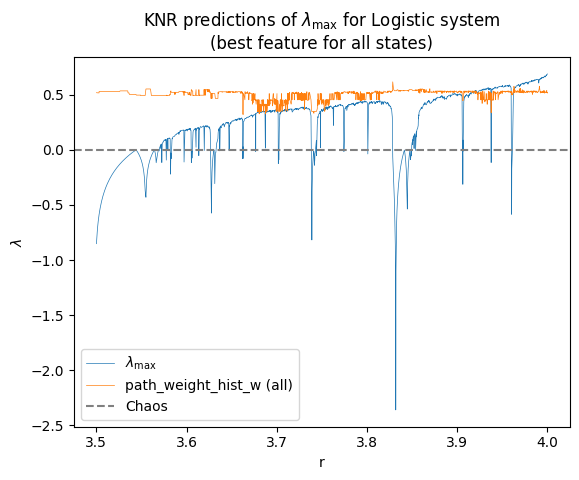

In [92]:
# plot the ground truth and regression predictions
plt.plot(test_params, y_test, lw=0.5, label=r"$\lambda_{\max}$")
plt.plot(test_params, y_pred_KNR_regression_all, lw=0.5, label=f"{best_regression_feature_KNR_all} (all)")
# plt.plot(test_params, y_pred_regression_chaos, lw=0.5, label=f"{best_correlation_chaos} (chaos)")

plt.xlabel(test_param_name)
plt.ylabel(r"$\lambda$")
plt.axhline(y=0, color='grey', linestyle='--', label='Chaos')
plt.legend()
plt.title(r"KNR predictions of $\lambda_{\max}$ for " + SYSTEM.capitalize() + " system\n(best feature for all states)")
plt.show()


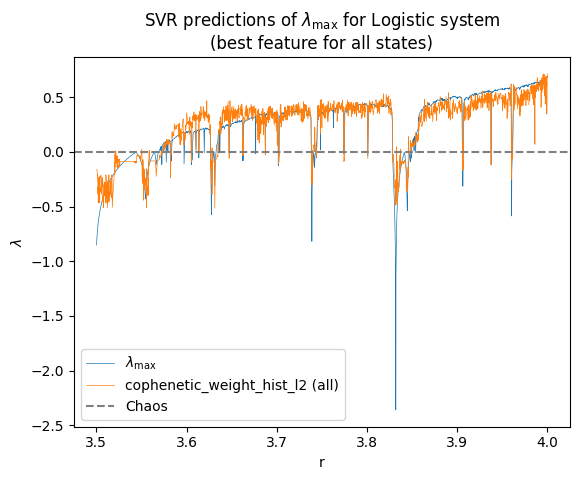

In [86]:
# plot the ground truth and regression predictions
plt.plot(test_params, y_test, lw=0.5, label=r"$\lambda_{\max}$")
plt.plot(test_params, y_pred_SVR_regression_all, lw=0.5, label=f"{best_regression_feature_SVR_all} (all)")
# plt.plot(test_params, y_pred_regression_chaos, lw=0.5, label=f"{best_correlation_chaos} (chaos)")

plt.xlabel(test_param_name)
plt.ylabel(r"$\lambda$")
plt.axhline(y=0, color='grey', linestyle='--', label='Chaos')
plt.legend()
plt.title(r"SVR predictions of $\lambda_{\max}$ for " + SYSTEM.capitalize() + " system\n(best feature for all states)")
plt.show()


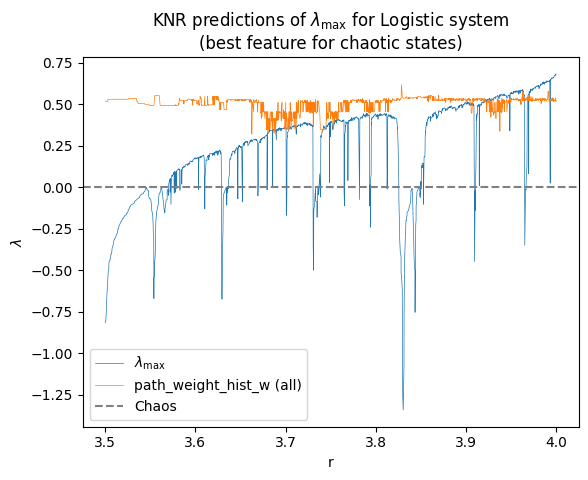

In [91]:
# plot the ground truth and regression predictions
plt.plot(test_params, y, lw=0.5, label=r"$\lambda_{\max}$")
plt.plot(test_params, y_pred_KNR_regression_chaos, lw=0.5, label=f"{best_regression_feature_KNR_chaos} (all)")

plt.xlabel(test_param_name)
plt.ylabel(r"$\lambda$")
plt.axhline(y=0, color='grey', linestyle='--', label='Chaos')
plt.legend()
plt.title(r"KNR predictions of $\lambda_{\max}$ for " + SYSTEM.capitalize() + " system\n(best feature for chaotic states)")
plt.show()


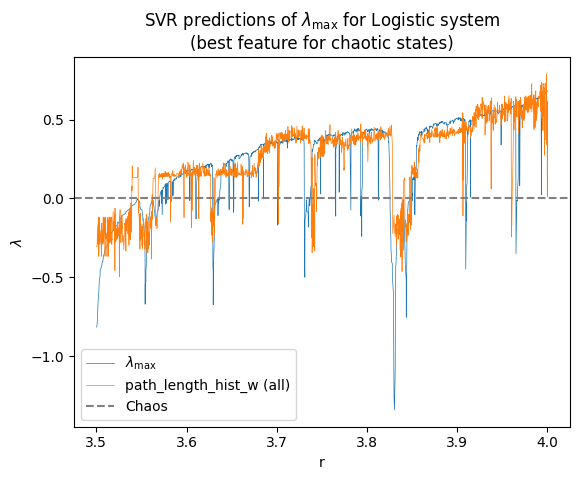

In [90]:
# plot the ground truth and regression predictions
plt.plot(test_params, y, lw=0.5, label=r"$\lambda_{\max}$")
plt.plot(test_params, y_pred_SVR_regression_chaos, lw=0.5, label=f"{best_regression_feature_SVR_chaos} (all)")

plt.xlabel(test_param_name)
plt.ylabel(r"$\lambda$")
plt.axhline(y=0, color='grey', linestyle='--', label='Chaos')
plt.legend()
plt.title(r"SVR predictions of $\lambda_{\max}$ for " + SYSTEM.capitalize() + " system\n(best feature for chaotic states)")
plt.show()


In [66]:
np.all(y_pred_classification)

False

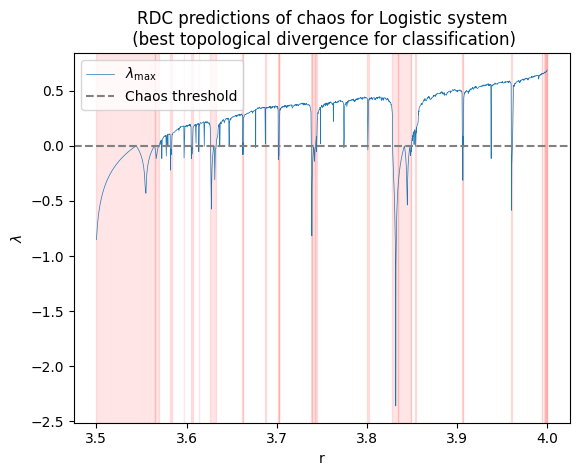

In [93]:
# plot the ground truth
plt.plot(test_params, y_test, lw=0.5, label=r"$\lambda_{\max}$")

# plot the classification predictions as vspans over the graph
predicted_non_chaos = y_pred_classification <= 1e-3
x = test_params

# mark sections of the x-axis where predicted_non_chaos is True
start = x[0] if predicted_non_chaos[0] else None
for i in range(1, len(predicted_non_chaos)):
    if not predicted_non_chaos[i-1] and predicted_non_chaos[i]:
        start = x[i-1]
    elif predicted_non_chaos[i-1] and not predicted_non_chaos[i]:
        if start is not None:
            plt.axvspan(start, x[i], color='red', alpha=0.1)
            start = None
    elif i == len(predicted_non_chaos)-1 and not predicted_non_chaos[i]:  # case for the end of the array
        if start is not None:
            plt.axvspan(start, x[i], color='red', alpha=0.1)

plt.xlabel(test_param_name)
plt.ylabel(r"$\lambda$")
plt.axhline(y=0, color='grey', linestyle='--', label='Chaos threshold')
plt.legend()
plt.title(r"RDC predictions of chaos for " + SYSTEM.capitalize() + " system\n (best topological divergence for classification)")
plt.show()


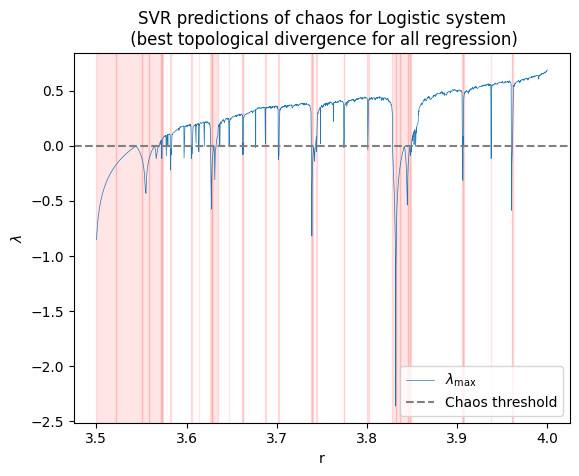

In [94]:
# plot the ground truth
plt.plot(test_params, y_test, lw=0.5, label=r"$\lambda_{\max}$")

# plot the classification predictions as vspans over the graph
predicted_non_chaos = y_pred_SVR_regression_all <= 1e-3
x = test_params

# mark sections of the x-axis where predicted_non_chaos is True
start = x[0] if predicted_non_chaos[0] else None
for i in range(1, len(predicted_non_chaos)):
    if not predicted_non_chaos[i-1] and predicted_non_chaos[i]:
        start = x[i-1]
    elif predicted_non_chaos[i-1] and not predicted_non_chaos[i]:
        if start is not None:
            plt.axvspan(start, x[i], color='red', alpha=0.1)
            start = None
    elif i == len(predicted_non_chaos)-1 and not predicted_non_chaos[i]:  # case for the end of the array
        if start is not None:
            plt.axvspan(start, x[i], color='red', alpha=0.1)

plt.xlabel(test_param_name)
plt.ylabel(r"$\lambda$")
plt.axhline(y=0, color='grey', linestyle='--', label='Chaos threshold')
plt.legend()
plt.title(r"SVR predictions of chaos for " + SYSTEM.capitalize() + " system\n (best topological divergence for all regression)")
plt.show()


### Hyperparameters of the divergence-based estimates

The following can be considered for variation in a wider-range study.

- Offset range and step size - equivalently offset range and number of offsets
- Dimension of the histogram vectors being compared
- Discrete vs piecewise linear merge trees
